In [1]:
#!/usr/bin/python
# updated DBR 11/2023 #

%matplotlib inline  

import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pandas as pd
import time
import scipy.stats as st

#ipython magic to make module autoreload
%load_ext autoreload
%autoreload 2

import seaborn as sns
sns.set_style("ticks")

#pull in the code to do the sims!
import ra_module
#import clones1126 as clmod

import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots

colormap=cm.jet

In [2]:
#read in ecology from past work for comparisons
outdf=pd.read_csv('../ecometrics_wprovirusrecalc.csv') #for comparing TCRs among different cohorts


In [3]:
#copied from clmod so it's all just here together

#function that solves stochastically using tau-leap method
def sim_clones(model0, T0, T0_model_param, rate_model, rate_model_param, net_clearance_rate, avg_pro_rate, avg_emerge_rate, t_redraw, dt, tF):
    
    sim_size0, clone_dist0 = make_initial_clones(model0, T0, T0_model_param) #use function to initialize the distribution
    
    xt=clone_dist0; xl=[]; tl=[]
    t=0
        
    #t_redraw = 100 #draw new rates every x days
    
    #make the initial rate vectors
    proli_rate_vector, death_rate_vector = make_vectors(
                rate_model, sim_size0, rate_model_param, net_clearance_rate, avg_pro_rate, avg_emerge_rate/T0)

    ir=1 #index for updating rates
    
    #loop over entire time 
    while t<tF:
        xl.append(xt); tl.append(t); #add states to list

        #reset the proliferation rate vectors every t_newrates days
        #next step is to include adjacency matrix so some clones are connected??
        if t > t_redraw*ir:
            proli_rate_vector, death_rate_vector = make_vectors(
                    rate_model, len(xt), rate_model_param, net_clearance_rate, avg_pro_rate, avg_emerge_rate/T0)
            ir+=1
        
        prolis=np.random.poisson(proli_rate_vector*xt*dt) #calculate proliferation events for the ith type
        deaths=np.random.poisson(death_rate_vector*xt*dt) #calculate death events for the ith type
        xt=xt+prolis-deaths #compute all updated states
        xt[xt<0]=0 #make sure no negative numbers
        t=t+dt #update time

        #totally new diversity, new clones
        #this shouldn't contribute to existing clones... but maybe its negligible
        births=np.random.poisson(avg_emerge_rate*dt) #calculate birth events for the ith type
        xt=np.append(xt,np.ones(births))
        
        emerge_proli_vector,emerge_death_vector=make_vectors(
                rate_model, births, rate_model_param, net_clearance_rate, avg_pro_rate, avg_emerge_rate/T0) #new rates for new clones
        
        proli_rate_vector=np.append(proli_rate_vector, emerge_proli_vector) #add on new vector   
        death_rate_vector=np.append(death_rate_vector, emerge_death_vector) #add on new vector   

    #postprocess sim_clones to make it an array
    Lf=len(xt) #the max length is that of the last time point
    ci_t=np.zeros([Lf,len(tl)])
    for i in range(len(tl)):
        ci_t[:len(xl[i]),i]=xl[i]

    return np.array(tl), ci_t
    
#initialize the clone distribution
def make_initial_clones(model0, T0, T0_model_param):
    
    #make initial clone sizes
    if model0=='const':
        clone_dist0=np.ones(int(T0/T0_model_param))*T0_model_param #uniform, all = parameter

    #make initial clone sizes
    if model0=='uni':
        clone_dist0=np.random.uniform(1,T0_model_param,[int(T0/T0_model_param)]) #uniform, all between 1 and rate param

    if model0=='exp':
        random_draws = np.random.exponential(T0_model_param,[T0])        
        clone_dist0=np.round(T0*random_draws/np.sum(random_draws))
        clone_dist0=clone_dist0[clone_dist0>0]

    if model0=='pwl':
        #random_draws = np.random.pareto(T0_model_param,[T0])
        #clone_dist0=np.round(T0*random_draws/np.sum(random_draws)) #power law-ish
        #clone_dist0=clone_dist0[clone_dist0>0]
        #sim_size0=len(clone_dist0)
        
        r=np.arange(1,T0)
        pa=r**-T0_model_param
        pa=pa/np.sum(pa)
        clone_dist0=np.random.multinomial(n=T0,pvals=pa,size=1)[0]
        clone_dist0=clone_dist0[clone_dist0>0]

    if model0=='pwl2':
        r=np.arange(1,T0)
        pa=r**-T0_model_param[0]+T0_model_param[2]*r**-T0_model_param[1]
        pa=pa/np.sum(pa)
        clone_dist0=np.random.multinomial(n=T0,pvals=pa,size=1)[0]
        clone_dist0=clone_dist0[clone_dist0>0]
        
    return len(clone_dist0), clone_dist0
    
#make rate arrays given the type of proliferation
def make_vectors(rate_model, sim_size, rate_model_param, net_clearance_rate, avg_pro_rate, avg_emerge_rate_T0scaled):
    
    #all proliferate the same
    if rate_model=='const':
        proli_rate_vector=np.ones(sim_size)*avg_pro_rate

    #all proliferate from uniform 
    if rate_model=='uni':
        proli_rate_vector=np.random.uniform(0,1,[sim_size])*avg_pro_rate

    #uneven proliferation (exponential)
    elif rate_model=='exp':
        proli_rate_vector=np.random.exponential(rate_model_param,[sim_size])*avg_pro_rate

    #uneven proliferation (powerlaw)
    elif rate_model=='pwl':
        proli_rate_vector=np.random.pareto(rate_model_param,[sim_size])*avg_pro_rate

    #2 types of proliferation, both follow exponential, but with different rates
    elif rate_model=='2const':
        n1=int(sim_size*rate_model_param[0]) #number in first phase -- larger clones
        n2=sim_size-n1
        proli_rate_vector=np.append(np.ones(n1)*avg_pro_rate[0],np.ones(n2)*avg_pro_rate[1])

    #2 types of proliferation, both follow exponential, but with different rates
    elif rate_model=='2exp':
        n1=int(sim_size*rate_model_param[0]) #number in first phase -- larger clones
        n2=sim_size-n1
        proli_rate_vector=np.append(np.random.exponential(rate_model_param[1],[n1])*avg_pro_rate[0],
                                    np.random.exponential(rate_model_param[2],[n2])*avg_pro_rate[1])
        
    death_rate_vector=proli_rate_vector - np.ones(sim_size)*(net_clearance_rate - avg_emerge_rate_T0scaled) #enforce balance of birth and death on clone level
        
    return  proli_rate_vector, death_rate_vector
    
#function to resample and compute R D1 and D2
def compute_ecology(unsorted_abunds,sample_size):

    pa=unsorted_abunds/np.sum(unsorted_abunds)
    
    rs = np.random.multinomial(n=sample_size,pvals=pa) #resampled abundance

    #calculate ecology and add to lists
    TCR=rs[rs>0]
    R=len(TCR);  
    r=np.arange(R)+1
    a=-np.sort(-TCR)
    pars=a/np.sum(a)
    cpa=np.cumsum(pars)
    D1=np.exp(-np.sum(pars*np.log(pars)))
    D2=1/np.sum(pars**2)
    
    return r,pars,a,R,D1,D2


In [4]:
#### fixed parameters across all models

tF=365*9 #9 years
dt=30 #monthly

sample_times=[10,20,80] #essentially in months (given dt)
c3=['tab:blue','tab:green','tab:red'] #colors for samples

ss=1e4; HIVss=100 #sample sizes

T0=10**6 #initial size of population, needs to be an integer

cHIV = 8000; cHIVint = 300; #HIV provirus parameters, from IPDA data, per million CD4

####



In [5]:
#change some things and run simulations!

#uniform T0 with T0 model param=100 (T0i), uniform proliferation, no reemergence, never redraw rates, no xi, full coverage
#fn='1'; m0='uni'; Tmp=100; rm='uni'; rmp=0; apr=0.01; ncr=0; aer=0; trd=20000; xi_def=0; xi_int=0; HIVfullycover=True 

#uniform T0 with T0 model param=100 (T0i), uniform proliferation, no reemergence, never redraw rates, no xi, random coverage
#fn='1.1'; m0='uni'; Tmp=100; rm='uni'; rmp=0; apr=0.01; ncr=0; aer=0; trd=20000; xi_def=0; xi_int=0; HIVfullycover=False 

#pwl T0 with T0 model param =0.8 (alpha), uniform proliferation, no reemergence, never redraw rates, no xi, random coverage
#fn='2'; m0='pwl'; Tmp=0.8; rm='uni'; rmp=0; apr=0.01; ncr=0; aer=0; trd=20000; xi_def=0; xi_int=0; HIVfullycover=False 

#pwl T0 with T0 model param =0.8 (alpha), exp proliferation, no reemergence, never redraw rates, no xi, random coverage
#fn='3.1'; m0='pwl'; Tmp=0.8; rm='exp'; rmp=1; apr=0.01; ncr=0; aer=0; trd=20000; xi_def=0; xi_int=0; HIVfullycover=False 
#^this one doesn't really help anything in particular?

#pwl T0 with T0 model param =0.8 (alpha), uni proliferation, no reemergence,  redraw rates every 6mo, no xi, random coverage
#fn='4'; m0='pwl'; Tmp=0.8; rm='uni'; rmp=0; apr=0.01; ncr=0; aer=0; trd=100; xi_def=0; xi_int=0; HIVfullycover=False 

#pwl T0 with T0 model param =0.8 (alpha), uni proliferation, no reemergence,  redraw rates every 6mo, 30mo hl for intact, random coverage
#fn='5'; m0='pwl'; Tmp=0.8; rm='uni'; rmp=0; apr=0.01; ncr=0; aer=0; trd=100; xi_def=np.log(2)/(161*30); xi_int=np.log(2)/(32*30); HIVfullycover=False 

#pwl T0 with T0 model param =0.8 (alpha), exp proliferation, no reemergence,  redraw rates every 6mo, 30mo hl for intact, random coverage
fn='6'; m0='pwl'; Tmp=0.8; rm='exp'; rmp=1; apr=0.01; ncr=0; aer=0; trd=100; xi_def=np.log(2)/(161*30); xi_int=np.log(2)/(32*30); HIVfullycover=False 


#use module to do the simulation
t,T = sim_clones(
        model0=m0,                 #type of initial condition distribution ['const','uni','exp','pwl']
        T0=T0,                        #initial number of T cells in simulation
        T0_model_param=Tmp,       #parameterize initial size distribution ['const','uni','exp','pwl']
        rate_model=rm,             #model for proliferation events, options: ['uni','exp','pwl','2phase']
        rate_model_param=rmp,           #parameterize distribution of proliferation rates disrtribution (a list if 2phase is chosen)
        net_clearance_rate=ncr,         #balance for T cells, net = prolif - death
        avg_pro_rate=apr,       #per day, TCM rate
        avg_emerge_rate=aer,    #cells/day, new
        t_redraw=trd,           #how often to redraw T cell proliferation rates, pick large to prevent
        dt=dt,                  #time step
        tF=tF                   #simulation days
)


In [6]:
#do simulation of HIV clones/proviruses among TCR

iTCRl=[]; fl=[]; iTCRlint=[]
iTCRlint_ind=[] #second index, which of the iTCR list are also intact
c=0
while c<cHIV: #with a little wiggle room?

    iTCR=np.random.randint(len(T)) #pick random one
    iTCRl.append(iTCR) #add it to list

    TCRclonesize=T[iTCR,0] #get that TCR clone size

    #pick the % of cells in taht TCR clone that are HIV infected (can start with all)?
    if HIVfullycover:
        HIVc = TCRclonesize
    else:
        HIVc = np.random.randint(0,TCRclonesize)

    fl.append(HIVc/TCRclonesize) #should be 1 unless not fully covered

    c += HIVc

    #note which one ares intact
    if np.random.rand()<cHIVint/cHIV:
        iTCRlint.append(iTCR)
        iTCRlint_ind.append(len(iTCRl))

TH=T[iTCRl,:] #T cell clonotypes that have some HIV proviruses
THint=T[iTCRlint,:] #same but intact

#now do calculation over time for proviruses
#for now assume HIV stays constant fraction -- if decays extra that just gets added additionally

fla = np.array(fl)
fla = np.tile(fla, (len(t),1)).T #copy it for all time points, same fraction

defdecay=np.tile(np.exp(-xi_def*t),(len(TH),1))
intdecay=np.tile(np.exp(-xi_int*t),(len(TH),1))

H=np.random.poisson(TH*fla*defdecay)

#H=POIS[H0*exp(-xi*t)]
#H[int] = POIS[H[int]*exp(-xii*t)] #another factor, would mean exponents would add?

H[iTCRlint_ind]=np.random.poisson(H[iTCRlint_ind]*intdecay[iTCRlint_ind]) #extra for intact


/Applications/anaconda/lib/python3.6/site-packages/matplotlib/ticker.py:2041: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


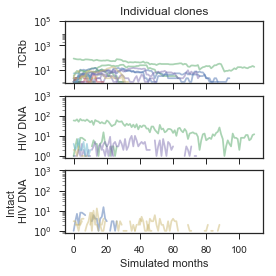

In [7]:
#examples of clone traces

fig,axs=plt.subplots(3,1,sharex=True,sharey=False,figsize=(4,4),)

num_examples=min([len(iTCRlint),30])

for j in range(num_examples):
    axs[0].semilogy(t/30,T[iTCRl[j],:],alpha=0.5)   
    axs[1].semilogy(t/30,H[j,:],alpha=0.5)   
    #axs[1].semilogy(t/30,T[iTCRl[j],:],alpha=0.5)   
    axs[2].semilogy(t/30,H[iTCRlint_ind[j]],alpha=0.5)   

#axs[0].semilogy(t/30,np.sum(T,axis=0),alpha=1,color='k')
#axs[1].semilogy(t/30,np.sum(T[iTCRl],axis=0),alpha=1,color='k')
#axs[2].semilogy(t/30,np.sum(T[iTCRlint],axis=0),alpha=1,color='k')

axs[0].set_ylabel('TCRb')
axs[0].set_title('Individual clones')
axs[1].set_ylabel('HIV DNA')
axs[2].set_ylabel('Intact \n HIV DNA')
axs[2].set_xlabel('Simulated months')

axs[0].set_ylim([0.8,1e5])
axs[1].set_ylim([0.8,1e3])
axs[2].set_ylim([0.8,1e3])
#axs[0].plot(t_mo,np.nansum(T,axis=0),color='k',ls='--')
20
plt.tight_layout()
plt.subplots_adjust(hspace = 0.2)
plt.subplots_adjust(wspace = 0.2)

plt.savefig('figures/'+fn+'-traces.pdf')


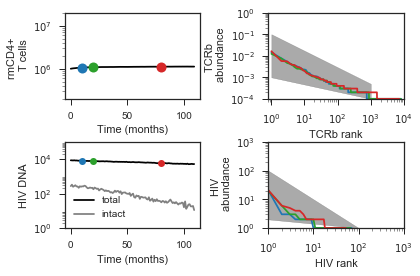

In [8]:
#rank abundance plots

plt.figure(figsize=(6,4))

#total TCR
plt.subplot(221)
plt.plot(t/30,np.sum(T,axis=0),color='k')

Dl=[] #list for Hill exponents
for i,iit in enumerate(sample_times):
    
    plt.subplot(221)    
    plt.semilogy(t[iit]/30,np.nansum(T[:,iit]),marker='o',ls='',markersize=10,color=c3[i])
    plt.xlabel('Time (months)')
    plt.ylabel('rmCD4+ \n T cells')  
    plt.ylim([2e5,2e7])

    #rank abundnace for TCR
    r,pars,a,RN,D1,D2 = compute_ecology(unsorted_abunds=T[:,iit],sample_size=ss)
    Dl.append([RN,D1,D2])
    
    plt.subplot(222)
    plt.loglog(r,pars,label=iit,color=c3[i])
    plt.xlabel('TCRb rank')
    plt.yticks(np.logspace(-4,0,5))
    plt.xticks([1,10,100,1e3,1e4])
    plt.ylabel('TCRb \n abundance')
    
    #plot comparison data (just use high and low from Fig 1 TCR rank abundances)
    plt.fill_between([1,1e3],[1e-1,5e-4],[1e-3,1e-4],color='gray',alpha=0.3)
    
#plt.legend()
plt.xlim([0.8,1e4])
plt.ylim([1e-4,1])

#HIV 
plt.subplot(223)
plt.plot(t/30,np.sum(H,axis=0),color='k',label='total')
plt.semilogy(t/30,np.sum(H[iTCRlint_ind],axis=0),color='gray',label='intact')
plt.legend(loc=3)
plt.xlabel('Time (months)')
plt.ylabel('HIV DNA')
plt.ylim([1,1e5])

HDl=[]
for i,iit in enumerate(sample_times):
    plt.subplot(223)
    
    plt.plot(t[iit]/30,np.sum(H[:,iit],axis=0),marker='o',ls='',color=c3[i])
    r,pars,a,RN,D1,D2 = compute_ecology(unsorted_abunds=H[:,iit],sample_size=HIVss)

    HDl.append([RN,D1,D2])

    #HIV model rank abundances
    plt.subplot(224)
    plt.loglog(r,a,label=iit,color=c3[i])
    plt.xlabel('HIV rank')
    plt.ylabel('HIV \n abundance')
    
    #plot comparison data (just use high and low from Fig 1 TCR rank abundances)
    plt.fill_between([1,100],[100,1],[2,1],color='gray',alpha=0.3)

plt.xlim([1,1e3])
plt.ylim([1,1e3])

plt.tight_layout()
plt.subplots_adjust(hspace = 0.5)
plt.subplots_adjust(wspace = 0.5)

plt.savefig('figures/'+fn+'-ras.pdf')


In [9]:
#find some TCR clonotypes that persist at leasst 50mo
#persistentTCR = np.where(T[iTCRl,50]>1)[0]

#find some HIV clonotypes that persist
persistentHIV = np.where(H[:,30]>1)[0]


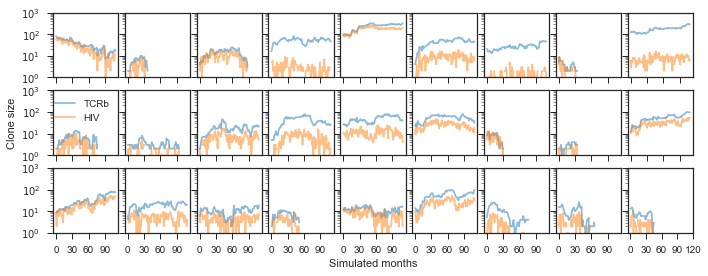

In [10]:
#examples of fractions infected
i=0
nx=3
ny=9
fig,axs=plt.subplots(nx,ny,sharex=True,sharey=True,figsize=(10,4),)
for j in range(ny*nx):
    jj=persistentHIV[j]
    ax=axs[j%nx][int(j/nx)]
    ax.plot(t/30,T[iTCRl[jj],:],color='tab:blue',alpha=0.5,label='TCRb')   #the index among TCR
    ax.plot(t/30,H[jj,:],color='tab:orange',alpha=0.5,label='HIV')   
    #ax.fill_between(t/30,np.ones(len(t))*0.1,T[iTCRl[jj],:]+0.1,color='tab:blue',alpha=1,label='TCRb')   #the index among TCR
    #ax.fill_between(t/30,np.ones(len(t))*0.1,H[jj,:]+0.1,color='tab:orange',alpha=1,label='HIV')   #the index among TCR

ax.set_ylim([1,1e3])
axs[1][0].set_ylabel('Clone size')
axs[1][0].legend()
axs[2][4].set_xlabel('Simulated months')

plt.semilogy()
ax.set_xticks(np.arange(0,121,30))
plt.tight_layout()
plt.subplots_adjust(hspace = .2)
plt.subplots_adjust(wspace = 0.1)

plt.savefig('figures/'+fn+'-bluepurp.pdf')


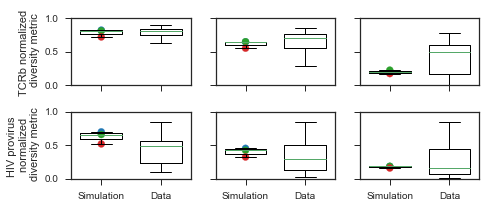

In [11]:
#normalized Hill coefficients

plt.figure(figsize=(4,3))

fig,axs=plt.subplots(2,3,sharex=True,sharey=True,figsize=(7,3))

axs[0][0].boxplot([np.array(Dl)[:,0]/ss,outdf['R']/ss],widths=0.7)
axs[0][0].scatter(np.ones(3),np.array(Dl)[:,0]/ss,c=c3)
#ax.xticks([1,2],['model','data'])

axs[0][1].boxplot([np.array(Dl)[:,1]/ss,outdf['D1']/ss],widths=0.7)
axs[0][1].scatter(np.ones(3),np.array(Dl)[:,1]/ss,c=c3)

axs[0][2].boxplot([np.array(Dl)[:,2]/ss,outdf['D2']/ss],widths=0.7)
axs[0][2].scatter(np.ones(3),np.array(Dl)[:,2]/ss,c=c3)

axs[0][0].set_ylabel('TCRb normalized \n diversity metric')
axs[0][0].set_xticklabels(['Simulation','Data'])

axs[1][0].boxplot([np.array(HDl)[:,0]/HIVss,outdf['RHIV'].dropna()/HIVss],widths=0.7)
axs[1][0].scatter(np.ones(3),np.array(HDl)[:,0]/HIVss,c=c3)

axs[1][1].boxplot([np.array(HDl)[:,1]/HIVss,outdf['D1HIV'].dropna()/HIVss],widths=0.7)
axs[1][1].scatter(np.ones(3),np.array(HDl)[:,1]/HIVss,c=c3)

axs[1][2].boxplot([np.array(HDl)[:,2]/HIVss,outdf['D2HIV'].dropna()/HIVss],widths=0.7)
axs[1][2].scatter(np.ones(3),np.array(HDl)[:,2]/HIVss,c=c3)

axs[1][0].set_ylabel('HIV provirus \n normalized \n diversity metric')
axs[1][0].set_xticklabels(['Simulation','Data'])

axs[0][0].set_ylim([0,1])
plt.tight_layout()
plt.savefig('figures/'+fn+'-sim-ecometrics.pdf')


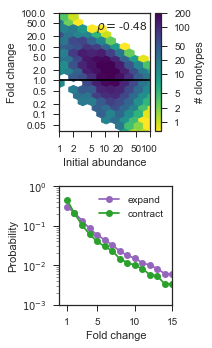

In [12]:
#clone dynamics

#now calculate clone shifts/fold expansions etc to mimic data
t1=sample_times[1]; t2=sample_times[2]
T1=T[:,t1]; T2=T[:,t2]

#drop zeros
T1z = T1[(T1>0) & (T2>0)]
T2z = T2[(T1>0) & (T2>0)]

#size t1 vs change in size
r=st.pearsonr(T1z,T2z-T1z)[0]
ratios=T2z/T1z

expands=ratios[ratios>1]
contracts=ratios[ratios<1]

plt.figure(figsize=(3,5))

plt.subplot(211)
plt.hexbin(np.log10(T1z),np.log10(T2z/T1z),gridsize=20,cmap='viridis_r',mincnt=1,bins='log',vmin=0.5,vmax=3)
plt.axhline(0,ls='-',color='black')
#plt.xlabel('log10 abundance, t1')
#plt.ylabel('log10 clone change, t1->t2')

plt.xlabel('Initial abundance')
plt.ylabel('Fold change')
plt.yticks(np.log10(np.array([1/100,1/50,1/20,1/10,1/5,1/2,1,2,5,10,20,50,100,200,500,1000])),np.array([1/100,1/50,1/20,1/10,1/5,1/2,1,2,5,10,20,50,100,200,500,1000]))
plt.ylim([-1.5,2])
plt.xticks(np.log10(np.array([1,2,5,10,20,50,100,200,500,1000])),np.array([1,2,5,10,20,50,100,200,500,1000]))
plt.xlim([0,2])
plt.annotate(r'$\rho=$'+str(np.round(st.spearmanr(np.log10(T1z),np.log10(T2z/T1z))[0],2)),[0.8,1.5])

cbar=plt.colorbar()
cbar.set_label(r'# clonotypes')
cbar.set_ticks(np.log10(np.array([1,2,5,10,20,50,100,200,500,1000])))
cbar.set_ticklabels(np.array([1,2,5,10,20,50,100,200,500,1000]))

#fit the expansion distributions
cz=['tab:purple','tab:green']
plt.subplot(212)
for j in range(2):
    fit_lamda_l=[]

    if j==0:
        pdist = expands
        tn='expand'
        binz=np.arange(0,26)+1
    if j==1:
        pdist = 1/contracts
        tn='contract'
        binz=np.arange(0,26)+1

    c,x = np.histogram(pdist,bins=binz,density=True)
    plt.plot(x[:-1],c,marker='o',ls='-',color=cz[j],label=tn)
  
    plt.legend()
    plt.semilogy()
    plt.ylim([1e-3,1])
    plt.xlim([0,15])
    plt.ylabel('Probability')
    plt.xlabel('Fold change')
    plt.xticks([1,5,10,15])

plt.tight_layout()
plt.savefig('figures/'+fn+'-foldchanges.pdf')


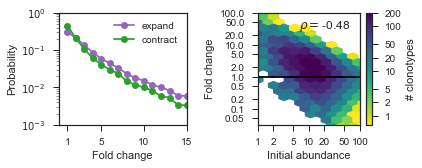

In [15]:
#clone dynamics

#now calculate clone shifts/fold expansions etc to mimic data
t1=sample_times[1]; t2=sample_times[2]
T1=T[:,t1]; T2=T[:,t2]

#drop zeros
T1z = T1[(T1>0) & (T2>0)]
T2z = T2[(T1>0) & (T2>0)]

#size t1 vs change in size
r=st.pearsonr(T1z,T2z-T1z)[0]
ratios=T2z/T1z

expands=ratios[ratios>1]
contracts=ratios[ratios<1]

plt.figure(figsize=(6,2.5))

plt.subplot(122)
plt.hexbin(np.log10(T1z),np.log10(T2z/T1z),gridsize=20,cmap='viridis_r',mincnt=1,bins='log',vmin=0.5,vmax=3)
plt.axhline(0,ls='-',color='black')
#plt.xlabel('log10 abundance, t1')
#plt.ylabel('log10 clone change, t1->t2')

plt.xlabel('Initial abundance')
plt.ylabel('Fold change')
plt.yticks(np.log10(np.array([1/100,1/50,1/20,1/10,1/5,1/2,1,2,5,10,20,50,100,200,500,1000])),np.array([1/100,1/50,1/20,1/10,1/5,1/2,1,2,5,10,20,50,100,200,500,1000]))
plt.ylim([-1.5,2])
plt.xticks(np.log10(np.array([1,2,5,10,20,50,100,200,500,1000])),np.array([1,2,5,10,20,50,100,200,500,1000]))
plt.xlim([0,2])
plt.annotate(r'$\rho=$'+str(np.round(st.spearmanr(np.log10(T1z),np.log10(T2z/T1z))[0],2)),[0.8,1.5])

cbar=plt.colorbar()
cbar.set_label(r'# clonotypes')
cbar.set_ticks(np.log10(np.array([1,2,5,10,20,50,100,200,500,1000])))
cbar.set_ticklabels(np.array([1,2,5,10,20,50,100,200,500,1000]))

#fit the expansion distributions
plt.subplot(121)
for j in range(2):
    fit_lamda_l=[]

    if j==0:
        pdist = expands
        tn='expand'
        binz=np.arange(0,26)+1
    if j==1:
        pdist = 1/contracts
        tn='contract'
        binz=np.arange(0,26)+1

    c,x = np.histogram(pdist,bins=binz,density=True)
    plt.plot(x[:-1],c,marker='o',ls='-',color=cz[j],label=tn)
  
    plt.legend()
    plt.semilogy()
    plt.ylim([1e-3,1])
    plt.xlim([0,15])
    plt.ylabel('Probability')
    plt.xlabel('Fold change')
    plt.xticks([1,5,10,15])

plt.tight_layout()
plt.savefig('figures/'+fn+'-foldchanges2.pdf')
